## <center> Decrypting Messages with MCMC </center>

In this notebook, we will decrypt a passage from the Great Gatsby that has been encrypted by remapping each symbol to a (usually) different one. For example, a text like 'my father...' might be encypted by 'lq!bhuwbt'. We assume that the mapping between symbols is one-to-one. The file symbols.txt gives the list of symbols, one per line. The file message.txt gives the encrypted message.

Decoding the message by brute force is impossible, since there are 53 symbols and thus 53! possible permutations to try. Instead we will set up a Markov chain Monte Carlo sampler tofind modes in the space of permutations.

We learn the transition statistics of letters and punctuation in English using a large text - War and Peace.

#### Import useful libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns

#### Load data

Read decrypted message

In [4]:
message = []
with open("message.txt") as text:
    for line in text:
        for letter in line:
            message.append(letter)
message = np.array(message)

n = len(message)

# print message to ensure it matches symbols in text
print(f"number of states: {n}")
print(f"number of unique symbols {len(np.unique(message))}")
print(f"sample text from war and peace: \n{''.join(message[:100])}")

number of states: 1445
number of unique symbols 32
sample text from war and peace: 
[:p1lpl]x:r?!pw:np1]!?pmx;:?!w.;?pl?w!gp1lp/ws-?!prwm?p1?pg]1?pwnm[2?ps-wsp[ m?p.??:psx!:[:rp]m?!p[:


Read symbols

In [5]:
symbols = np.loadtxt("symbols.txt", dtype="str", delimiter="\n")
s = len(symbols)
print(f"number of unique symbols: {s} \nsymbols: \n{symbols}")

number of unique symbols: 53 
symbols: 
['=' ' ' '-' ',' ';' ':' '!' '?' '/' '.' "'" '"' '(' ')' '[' ']' '*' '0'
 '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i'
 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


#### Read war and peace (core text)

In [6]:
# note: covert to lower case as symbols in lower case
text_corpus_raw = []
with open("war_and_peace.txt") as text:
    for line in text:
        text_corpus_raw.append(line.lower()) 
print(text_corpus_raw[:10])

['\n', '\n', '\n', 'chapter i\n', '\n', '"well, prince, so genoa and lucca are now just family estates of the buonapartes. but i warn you, if you don\'t tell me that this means war,\n', 'if you still try to defend the infamies and horrors perpetrated by that\n', 'antichrist—i really believe he is antichrist—i will have nothing\n', 'more to do with you and you are no longer my friend, no longer my\n', "'faithful slave,' as you call yourself! but how do you do? i see i\n"]


#### Clean war and peace text

In [7]:
# 1. remove empty lines indicated by "\n" and Chapter numbers e.g. 'CHAPTER I'

text_corpus = []

for text in text_corpus_raw:
    if text != '\n':
        if 'chapter' not in text:
            text_corpus.append(text)
print(text_corpus[:3],"\n")

# change \n in text to space
text_corpus = [s.replace('\n', ' ') for s in text_corpus] 
print(text_corpus[:3])

['"well, prince, so genoa and lucca are now just family estates of the buonapartes. but i warn you, if you don\'t tell me that this means war,\n', 'if you still try to defend the infamies and horrors perpetrated by that\n', 'antichrist—i really believe he is antichrist—i will have nothing\n'] 

['"well, prince, so genoa and lucca are now just family estates of the buonapartes. but i warn you, if you don\'t tell me that this means war, ', 'if you still try to defend the infamies and horrors perpetrated by that ', 'antichrist—i really believe he is antichrist—i will have nothing ']


In [8]:
# 2. split corpus in letters and store them in an array
text_corpus_final = []
for line in text_corpus:
    words = re.split(r'(\s+)', line)
    for word in words:
        for letter in word:
            text_corpus_final.append(letter)

text_corpus_final = np.array(text_corpus_final)

np.unique(text_corpus_final)

array([' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1',
       '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'a',
       'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à',
       'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ó',
       'ô', 'ö', 'ú', 'ü', 'ý', 'œ', '—'], dtype='<U1')

In [9]:
# 3. replace french letters with english equivalents
letters_to_replace = np.unique(text_corpus_final)[51:72]
replacement_letters = np.array(['a','a','a','a','ae','c','e',
                                'e','e','e','i','i','i','o',
                                'o','o','u','u','y','oe','-'])
print("letter replacement pairs:")
for i, letter in enumerate(letters_to_replace):
    print(f'({letter}->{replacement_letters[i]})')


letter replacement pairs:
(à->a)
(á->a)
(â->a)
(ä->a)
(æ->ae)
(ç->c)
(è->e)
(é->e)
(ê->e)
(ë->e)
(í->i)
(î->i)
(ï->i)
(ó->o)
(ô->o)
(ö->o)
(ú->u)
(ü->u)
(ý->y)
(œ->oe)
(—->-)


In [10]:
example_iter = 0
print("example replacements:")

for index, letter  in enumerate(letters_to_replace):
    # for each letter that needs to be replaced, find indices of 
    # letters in the corpus and swap them with the respective 
    # letter in the replacement list
    
    # get indices of letters to be replaced
    indices = np.argwhere(text_corpus_final==letter)
    
    # print example replacement for validation
    if example_iter % 5 == 0:
        print(f"{letter}->{replacement_letters[index]}")
    
    text_corpus_final[indices] = replacement_letters[index]
    
    example_iter +=1

example replacements:
à->a
ç->c
í->i
ö->o
—->-


In [11]:
n_corpus = len(text_corpus_final)

symbols_corpus = np.unique(text_corpus_final)

print(f"number of states: {n_corpus}")
print(f"number of unique symbols {len(symbols_corpus)}")
print(f"sample text from war and peace: \n{text_corpus_final[:100]}")

number of states: 3183812
number of unique symbols 51
sample text from war and peace: 
['"' 'w' 'e' 'l' 'l' ',' ' ' 'p' 'r' 'i' 'n' 'c' 'e' ',' ' ' 's' 'o' ' '
 'g' 'e' 'n' 'o' 'a' ' ' 'a' 'n' 'd' ' ' 'l' 'u' 'c' 'c' 'a' ' ' 'a' 'r'
 'e' ' ' 'n' 'o' 'w' ' ' 'j' 'u' 's' 't' ' ' 'f' 'a' 'm' 'i' 'l' 'y' ' '
 'e' 's' 't' 'a' 't' 'e' 's' ' ' 'o' 'f' ' ' 't' 'h' 'e' ' ' 'b' 'u' 'o'
 'n' 'a' 'p' 'a' 'r' 't' 'e' 's' '.' ' ' 'b' 'u' 't' ' ' 'i' ' ' 'w' 'a'
 'r' 'n' ' ' 'y' 'o' 'u' ',' ' ' 'i' 'f']


#### Estimate the transition probability matrix

Initialise transition matrix to 1 (before normalisation), which corresponds to setting the prior to a uniform distribution i.e. each transition is equally likely. This avoids probabilities of 0 in the transition matrix

In [12]:
Psi = np.ones((s, s))

print("first 5 transitions:")

for i_n, s_i in enumerate(text_corpus_final[:-1]):
    s_j = text_corpus_final[i_n+1]
    
    i_t = np.argwhere(symbols==s_i)[0][0]
    j_t = np.argwhere(symbols==s_j)[0][0]
    
    if i_n in np.arange(5):
        print(f"{s_i}->{s_j}")
    
    Psi[i_t, j_t] +=1

first 5 transitions:
"->w
w->e
e->l
l->l
l->,


In [13]:
# normalise each row (transitions out of state i)
Psi_norm = Psi / np.sum(Psi, axis=1, keepdims=True)

# check if normalised correctly
np.sum(Psi_norm, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

#### Plot transition probability matrix

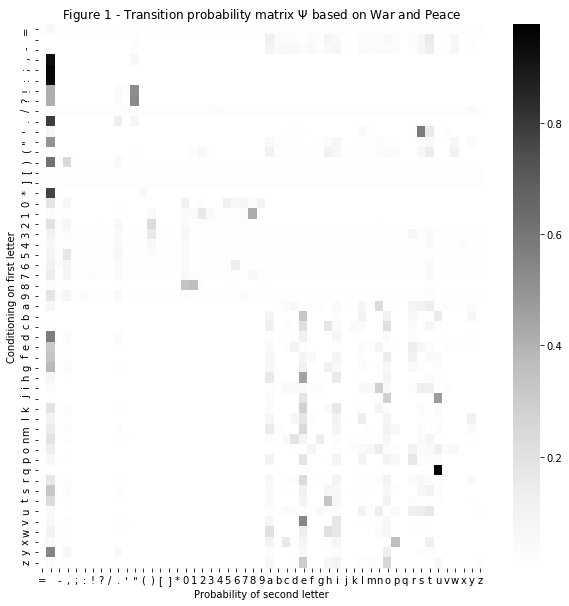

In [14]:
fig1 = plt.figure(figsize=(10,10))

ax = sns.heatmap(Psi_norm, cmap="Greys", cbar=True, 
           xticklabels=symbols, yticklabels=symbols)

# format plot
ax.set_title("Figure 1 - Transition probability matrix $\Psi$ based on War and Peace")
ax.set_ylabel("Conditioning on first letter")
ax.set_xlabel("Probability of second letter")

# save plot
fig1.savefig('fig1.png')

#### Estimate the stationary distribution

The stationary distribution is the transpose of the left eigenvector of Psi corresponding to eigenvalue of 1. Left eigenvectors are the eigenvectors of Psi transpose

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(Psi_norm.T)
eigenvalues       

array([ 1.00000000e+00+0.j        ,  4.80142706e-01+0.j        ,
        6.00957066e-02+0.30618027j,  6.00957066e-02-0.30618027j,
       -3.69448263e-01+0.j        , -3.07694743e-01+0.j        ,
       -2.16135361e-01+0.12172211j, -2.16135361e-01-0.12172211j,
        1.92059282e-01+0.j        ,  1.36089092e-01+0.j        ,
       -4.85065489e-02+0.10485725j, -4.85065489e-02-0.10485725j,
        8.04875770e-03+0.10760095j,  8.04875770e-03-0.10760095j,
       -7.11269612e-02+0.06561815j, -7.11269612e-02-0.06561815j,
        1.03206413e-01+0.02470657j,  1.03206413e-01-0.02470657j,
        1.02829959e-01+0.j        ,  9.26148054e-02+0.j        ,
       -7.60404721e-02+0.j        ,  3.13578070e-02+0.06296869j,
        3.13578070e-02-0.06296869j,  7.32825971e-02+0.j        ,
       -2.03674595e-02+0.05672424j, -2.03674595e-02-0.05672424j,
        4.63268717e-02+0.j        ,  4.31602118e-02+0.01497233j,
        4.31602118e-02-0.01497233j,  3.12128501e-02+0.03005984j,
        3.12128501e-02-0.

In [16]:
# find the index of eigenvalue = 1
index = np.argmin(np.abs(eigenvalues - 1))
index

0

In [17]:
phi = np.real(eigenvectors[:, index]).T

# normalise eigenvector to get a probability distr.
phi = phi/np.sum(phi)
phi

array([1.72596605e-05, 1.76673507e-01, 1.23014250e-03, 1.24875231e-02,
       3.75632945e-04, 3.21971153e-04, 1.24834447e-03, 1.00043300e-03,
       1.72596598e-05, 9.63784234e-03, 2.37681291e-03, 5.64958776e-03,
       2.20610036e-04, 2.20610460e-04, 1.66320358e-05, 1.66320358e-05,
       1.01988979e-04, 5.99380969e-05, 1.10148078e-04, 5.52309399e-05,
       3.07535871e-05, 2.10254072e-05, 2.85568797e-05, 3.01259583e-05,
       2.69878363e-05, 6.77833902e-05, 2.44773378e-05, 6.40543799e-02,
       1.08017234e-02, 1.89373038e-02, 3.69698839e-02, 9.81268382e-02,
       1.71215895e-02, 1.59924886e-02, 5.21596486e-02, 5.40261845e-02,
       7.96454881e-04, 6.38136871e-03, 3.01545154e-02, 1.92486047e-02,
       5.74859700e-02, 6.01094465e-02, 1.39332582e-02, 7.44676133e-04,
       4.59966932e-02, 5.08934170e-02, 7.03547874e-02, 2.03886839e-02,
       8.36685694e-03, 1.85098811e-02, 1.18056099e-03, 1.44315790e-02,
       7.65387553e-04])

#### Plot stationary distribution

In [18]:
# 1D to 2D as imshow requires a 2D+ input
phi = np.reshape(phi,(1,len(phi))) 

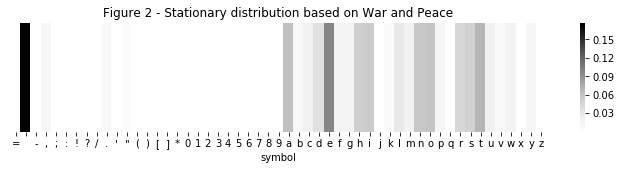

In [19]:
fig2 = plt.figure(figsize=(12,2))

ax = sns.heatmap(phi, cmap="Greys", cbar=True, xticklabels=symbols)

# format plot
ax.set_yticks([])
ax.set_title("Figure 2 - Stationary distribution based on War and Peace")
ax.set_xlabel("symbol")

# save plot
fig2.savefig('fig2.png')

#### Initilise mapping (sigma)

Use as reference the frequency of the words in "War and Peace"

In [20]:
# number of sampling iterations
iter = 10_000 

sigma = np.copy(symbols)

In [21]:
# get unique symbols and their frequencies from the War and Peace text
unique_ref, counts_ref = np.unique(text_corpus_final, return_counts=True)

# get unique symbols and their frequencies from the encoded message
unique_enc, counts_enc = np.unique(message, return_counts=True)

In [22]:
# sort symbols in "War and Peace" from highest to lowest frequency
symbols_reference = unique_ref[np.argsort(counts_ref)[::-1]]
symbols_reference

array([' ', 'e', 't', 'a', 'o', 'n', 'i', 'h', 's', 'r', 'd', 'l', 'u',
       'm', 'c', 'w', 'f', 'g', 'y', 'p', ',', 'b', '.', 'v', 'k', '"',
       "'", '!', '-', 'x', '?', 'j', 'z', 'q', ';', ':', '(', ')', '1',
       '*', '8', '0', '2', '3', '6', '5', '7', '9', '4', '/', '='],
      dtype='<U1')

In [23]:
# sort symbols in encoded message from highest to lowest frequency
symbols_encoded = unique_enc[np.argsort(counts_enc)[::-1]]
symbols_encoded

array(['p', '?', 'w', 's', '[', ':', 'g', ']', '!', ';', '-', 'x', '1',
       'n', '2', 'l', 'm', 'r', '/', '.', 'u', 'z', ',', '5', '9', ' ',
       '6', '7', 'c', 'v', '0', '4'], dtype='<U1')

Adjust sigma to reflect frequency of symbols

In [24]:
i=0

while i < min(len(unique_ref), len(unique_enc)):
    
    # get index of target symbol whose encoding will be changed
    idx_new = np.argwhere(symbols==symbols_reference[i])[0][0]
    
    # save current encoding of target symbol
    encoding_prev = sigma[idx_new]
    
    # get new encoding of target symbol
    encoding_new = symbols_encoded[i]
    
    # get current index of the encoding that will be assigned 
    # to the target symbol
    idx_prev = np.argwhere(sigma==encoding_new)[0][0]
    
    # swap the two symbols
    sigma[idx_new] = encoding_new
    
    sigma[idx_prev] = encoding_prev
    
    i+=1

In [25]:
print("Mapping initialised as follows:")
for i,j in zip(symbols,sigma):
    print(f"σ({i}) = {j}")

Mapping initialised as follows:
σ(=) = =
σ( ) = p
σ(-) = c
σ(,) = u
σ(;) = i
σ(:) = f
σ(!) = 7
σ(?) = 0
σ(/) = y
σ(.) = ,
σ(') = 6
σ(") =  
σ(() = (
σ()) = )
σ([) = o
σ(]) = h
σ(*) = *
σ(0) = e
σ(1) = "
σ(2) = d
σ(3) = 3
σ(4) = j
σ(5) = t
σ(6) = '
σ(7) = a
σ(8) = 8
σ(9) = k
σ(a) = s
σ(b) = z
σ(c) = 2
σ(d) = -
σ(e) = ?
σ(f) = m
σ(g) = r
σ(h) = ]
σ(i) = g
σ(j) = 4
σ(k) = 9
σ(l) = x
σ(m) = n
σ(n) = :
σ(o) = [
σ(p) = .
σ(q) = q
σ(r) = ;
σ(s) = !
σ(t) = w
σ(u) = 1
σ(v) = 5
σ(w) = l
σ(x) = v
σ(y) = /
σ(z) = b


In [26]:
def generate_mapping(sigma):
    """
    Generates new mapping by swapping uniformly at random
    two different symbols
    Input:
        sigma: current mapping (numpy array)
    Output: 
        sigma_new: new mapping (numpy array)
    """
    sigma_new = np.copy(sigma)

    idx1 = np.random.choice(len(sigma))
    idx2 = np.random.choice(len(sigma))
    
    if idx1==idx2:
        sigma_new = generate_mapping(sigma)
    else:
        temp = sigma_new[idx1]
        sigma_new[idx1] = sigma_new[idx2]
        sigma_new[idx2] = temp
        
    return sigma_new

In [27]:
def get_logscore(message, sigma, Psi_norm):
    """
    Calculates log-likelihood of encoded message, 
    which is equal to sum of the log of the transition
    probabilities
    Input:
        message: encoded text (numpy array)
        sigma: current mapping (numpy array)
        Psi_norm: transition probability matrix for 
                  symbols in the English vocabulary
    """
    log_l=0
    
    for i in range(len(message)-1):
        
        s_i = np.argwhere(sigma == message[i])[0][0]
        s_j = np.argwhere(sigma == message[i+1])[0][0]
        
        # Because the message is large, the marginal prob. of the first
        # character contributes very little to the overall log-likelihood. 
        # Thus, we approximate the log likelihood by dropping that term
        
        log_l += np.log(Psi_norm[s_i][s_j])
        
    return log_l

In [28]:
# list that stores the log-likehood of the encrypted text in each iter
likelihoods = []

for i in range(iter):
    # propose new mapping
    sigma_new = generate_mapping(sigma)
    
    # get log-likelihood of encoded text using current mapping
    log_sigma = get_logscore(message, sigma, Psi_norm)
    
    # store current log-likelihood
    likelihoods.append(log_sigma)

    # get log-likelihood of encoded text using proposed mapping
    log_sigma_new = get_logscore(message, sigma_new, Psi_norm)
    
    # calculate the acceptance ratio
    a = np.exp(log_sigma_new-log_sigma)
    
    u = np.random.uniform()
    
    if u <= min(1, a):
        sigma = sigma_new
    
    # output decryption of first 60 symbols every 100 iterations
    if i %100==0:
        message_decrypted = np.copy(message)
        
        for k in range(len(message)):
            idx_encoded = np.argwhere(sigma==message[k])[0][0]
            message_decrypted[k] = symbols[idx_encoded]
        
        sample_string = ''.join(message_decrypted[:60])
        print(f"On iter: {i} {sample_string}")

On iter: 0 on uw whlnges tnm uhse flrnestpre wetsi uw ytades gtfe ue ih
On iter: 100 mi uw woliger tik uore .lsiertpse wetrn uw ytader gt.e ue no
On iter: 200 mi pw woliger tik pore blsiertuse wetrn pw dtayer gtbe pe no
On iter: 300 mi pw woliger tik pore blsiertuse wetrn pw dtayer gtbe pe no
On iter: 400 ui pw wotiger lik pore btsierlmse welrn pw dlayer glbe pe no
On iter: 500 ul fw woalger ilk fore baslerimse weirn fw dityer gibe fe no
On iter: 600 ul fw woalger ilk fore baslerimse weirn fw dityer gibe fe no
On iter: 700 ul fw woalger ilk fore baslerimse weirn fw dityer gibe fe no
On iter: 800 ul fw woalger ilk fore baslerimse weirn fw dityer gibe fe no
On iter: 900 ul fw woalger ilk fore baslerimse weirn fw dityer gibe fe no
On iter: 1000 al kw woulger ilf kore musleribse weirn kw dityer gime ke no
On iter: 1100 al kw woulger ilf kore musleribse weirn kw dityer gime ke no
On iter: 1200 an mw wounger inf more kusneribse weirl mw dityer gike me lo
On iter: 1300 an mk kounger ind more 

In [29]:
# print final decrypted message
print(''.join(message_decrypted))

in my younger and more vulnerable years my father gave me some advice that i've been turning over in my mind ever since. "whenever you feel like criticizing any one," he told me, "just remember that all the people in this world haven't had the advantages that you've had." he didn't say any more but we've always been unusually communicative in a reserved way, and i understood that he meant a great deal more than that. in consequence i'm inclined to reserve all judgments, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college i was unjustly accused of being a politician, because i was privy to the secret griefs of wild, unknown men. most of the confidences were unsought--frequently i have feigned sleep, preoccupation, or a hostile levity when i realized by some unmistakable sign that an intim

In [30]:
with open('decrypted_message.txt', 'w') as f:
    f.write(''.join(message_decrypted))

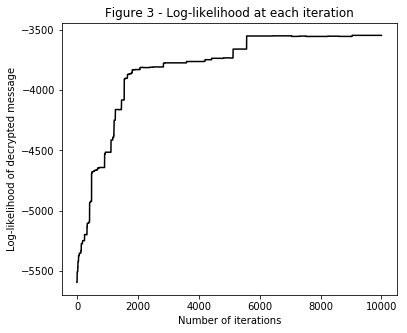

In [31]:
fig3 = plt.figure(figsize=(6,5))

plt.plot(likelihoods, c='black')

# format plot
plt.title('Log-likelihood at each iteration')
plt.ylabel('Log-likelihood of decrypted message')
plt.xlabel('Number of iterations')

Credits:

This exercise has been designed by Dr Maneesh Sahani as part of the Approximate Inference module at UCL.